In [1]:
import os
import cv2
import tqdm
import time
import string
import pathlib
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix

from typing import List
from matplotlib import pyplot as plt

from predict import Prediction
from utils.rgb import mask2rgb
from utils.prediction.evaluations import visualize, preload_image_data

# Logging
from utils.logging import logging

log = logging.getLogger(__name__)
log.setLevel(logging.INFO)

c:\Posao\firebot-segmentation\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Variables

In [2]:
metrics_models = [
    { 
        'model_name': 'U-Net 256x256',
        'model_path': r'checkpoints/avid-forest-323/best-checkpoint.pth.tar',
        'patch_size': 256,
    },
    { 
        'model_name': 'U-Net 512x512',
        'model_path': r'checkpoints/helpful-sky-334/best-checkpoint.pth.tar',
        'patch_size': 512,
    },
   { 
        'model_name': 'U-Net 640x640',
        'model_path': r'checkpoints/graceful-snowball-337/best-checkpoint.pth.tar',
        'patch_size': 640,
    }, 
    { 
        'model_name': 'U-Net 768x768',
        'model_path': r'checkpoints/silvery-serenity-371/best-checkpoint.pth.tar',
        'patch_size': 768,
    },
    { 
        'model_name': 'U-Net 800x800',
        'model_path': r'checkpoints/kind-totem-369/best-checkpoint.pth.tar',
        'patch_size': 800,
    },
    { 
        'model_name': 'U-Net 864x864',
        'model_path': r'checkpoints/swept-field-374/best-checkpoint.pth.tar',
        'patch_size': 864,
    },
    { 
        'model_name': 'U-Net 960x960',
        'model_path': r'checkpoints/giddy-leaf-375/best-checkpoint.pth.tar',
        'patch_size': 960,
    },
    { 
        'model_name': 'U-Net 1088x1088',
        'model_path': r'checkpoints/masked-orb-376/best-checkpoint.pth.tar',
        'patch_size': 1088,
    },
]
metrics_model_index = 2

metrics_output = pathlib.Path('metrics_output')
model_metrics_output = pathlib.Path(metrics_output, metrics_models[metrics_model_index]['model_name'])

# Create directory if it doesn't exists
if not os.path.isdir(model_metrics_output):
    os.makedirs(model_metrics_output)

## Util Functions

In [3]:
log.info('[DATA]: Started preloading test images and labels!')
test_imgs = preload_image_data(r'data', r'imgs', False, metrics_models[metrics_model_index]['patch_size'])
test_labels = preload_image_data(r'data', r'imgs', True, metrics_models[metrics_model_index]['patch_size'])

[DATA]: Started preloading test images and labels!


## Model prediction

In [4]:
model_params = {
    'model_name': metrics_models[metrics_model_index]['model_path'],
    'patch_width': metrics_models[metrics_model_index]['patch_size'],
    'patch_height': metrics_models[metrics_model_index]['patch_size'],
    'n_channels': 3,
    'n_classes': 3
}
model = Prediction(model_params)
model.initialize()

log.info('[PREDICTION]: Model loaded!')
log.info(f'[PREDICTION]: Starting prediction on {len(test_imgs)} image(s).')

predicted_labels = []
img_process_time_list = []
m_ious = []

batch_start_time = time.time()
pbar = tqdm.tqdm(enumerate(test_imgs), total=len(test_imgs))
for i, img in pbar:
    img_start_time = time.time()
    mask_predict = model.predict_image(img)
    img_process_time = time.time() - img_start_time

    predicted_labels.append(mask_predict)
    img_process_time_list.append(img_process_time * 1000)

pbar.close()
batch_process_time = time.time() - batch_start_time

[PREDICTION]: Loading model checkpoints/graceful-snowball-337/best-checkpoint.pth.tar
[PREDICTION]: Model loaded!
[PREDICTION]: Starting prediction on 683 image(s).


100%|██████████| 683/683 [00:31<00:00, 21.74it/s]


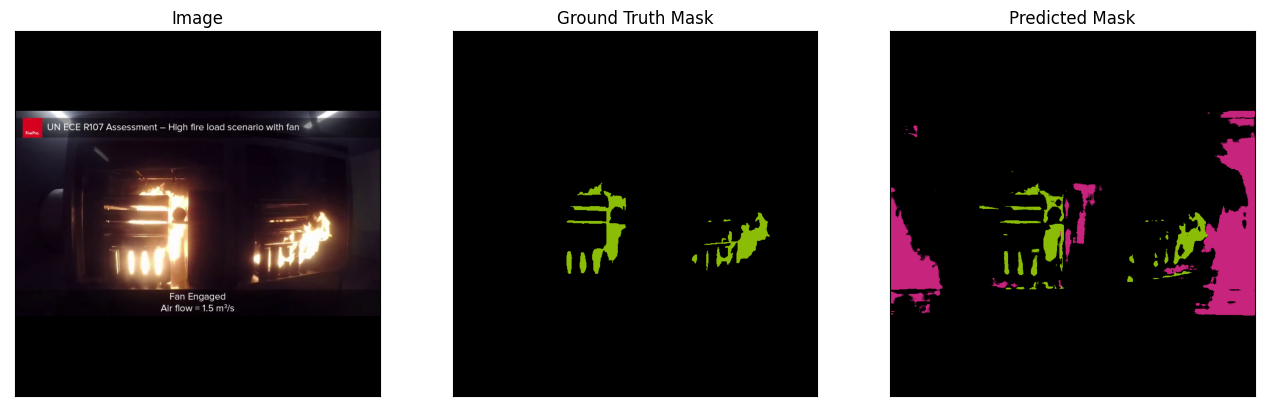

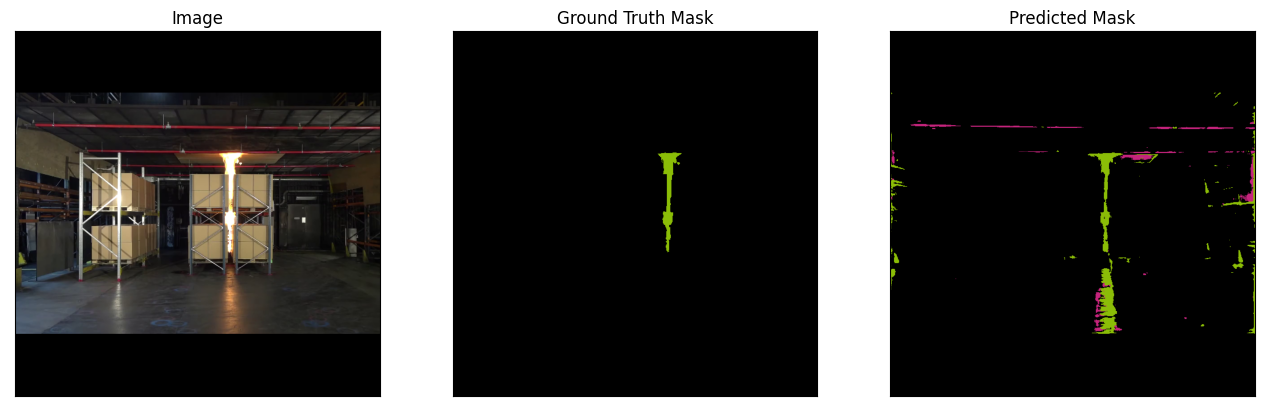

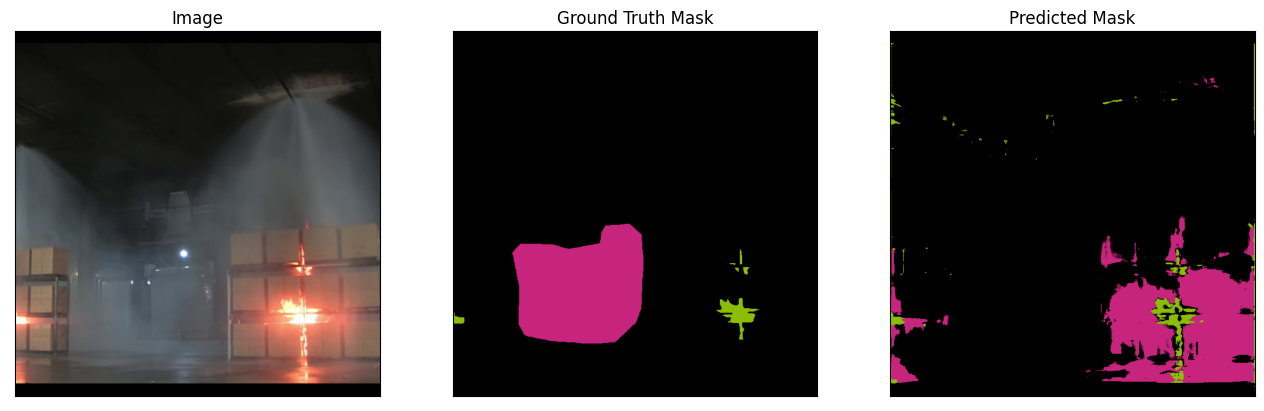

In [5]:
visualize(
    save_path=model_metrics_output,
    prefix='1',
    image=test_imgs[8], 
    ground_truth_mask=mask2rgb(test_labels[8]), 
    predicted_mask=mask2rgb(predicted_labels[8]),
)

visualize(
    save_path=model_metrics_output,
    prefix='2',
    image=test_imgs[16], 
    ground_truth_mask=mask2rgb(test_labels[16]), 
    predicted_mask=mask2rgb(predicted_labels[16]),
)

visualize(
    save_path=model_metrics_output,
    prefix='3',
    image=test_imgs[32], 
    ground_truth_mask=mask2rgb(test_labels[32]), 
    predicted_mask=mask2rgb(predicted_labels[32]),
)

### Getting Metrics

In [6]:
# Vars
gt_list_fire = []
pred_list_fire = []

gt_list_smoke = []
pred_list_smoke = []


log.info('[METRICS]: Started converting RGB masks to binary masks!')
pbar = tqdm.tqdm(enumerate(test_labels), total=len(test_labels))
for i, label in pbar:
    # Fire
    ground_truth_fire = cv2.inRange(label, 1, 1)
    prediction_fire = cv2.inRange(predicted_labels[i], 1, 1)

    gt_mapped_fire = ground_truth_fire.flatten().astype('float') / 255
    pred_mapped_fire = prediction_fire.flatten().astype('float') / 255

    gt_list_fire.append(gt_mapped_fire)
    pred_list_fire.append(pred_mapped_fire)

    # Smoke
    ground_truth_smoke = cv2.inRange(label, 2, 2)
    prediction_smoke = cv2.inRange(predicted_labels[i], 2, 2)

    gt_mapped_smoke = ground_truth_smoke.flatten().astype('float') / 255
    pred_mapped_smoke = prediction_smoke.flatten().astype('float') / 255

    gt_list_smoke.append(gt_mapped_smoke)
    pred_list_smoke.append(pred_mapped_smoke)
pbar.close()

# Global Vars
gt_flatten_fire, pred_flatten_fire = np.asarray(gt_list_fire).flatten(), np.asarray(pred_list_fire).flatten()
gt_flatten_smoke, pred_flatten_smoke = np.asarray(gt_list_smoke).flatten(), np.asarray(pred_list_smoke).flatten()

# Remove Unused Data From Memory
log.info('[METRICS]: Started converting RGB masks to binary masks!')
del test_imgs
del test_labels

[METRICS]: Started converting RGB masks to binary masks!


100%|██████████| 683/683 [00:03<00:00, 171.00it/s]


[METRICS]: Started converting RGB masks to binary masks!


### McNemar's Evaluations

In [7]:
from scipy import stats
from decimal import *

fire_confusion = confusion_matrix(gt_flatten_fire, pred_flatten_fire)

In [11]:
mcnemar_stats = ((fire_confusion[0, 1] - fire_confusion[1, 0]) ** 2) / (fire_confusion[0, 1] + fire_confusion[1, 0])
degree_of_freedom = (len(fire_confusion[0]) - 1) * (len(fire_confusion[1]) - 1)

In [24]:
r1 = 1 - stats.chi2.cdf(mcnemar_stats, degree_of_freedom)
r2 = stats.chi2.sf(mcnemar_stats, degree_of_freedom)

print(fire_confusion)
print(mcnemar_stats, degree_of_freedom)
print(r1, r2)

[[268137902   4449966]
 [  3443664   3725268]]
4449966
128286.18964962888 1
0.0 0.0


In [ ]:
from statsmodels.stats.contingency_tables import mcnemar

print(mcnemar(fire_confusion, exact=False))
print(mcnemar(fire_confusion, exact=False, correction=False))